In [1]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 9)


In [2]:
tickers = ['TQQQ','TMF']
dualtickers = ['BND','PQTIX']
lag = 1
resample_monthly = False

In [3]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min() + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets.head(30))

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
PQTIX 2014-01-06 00:00:00
asset 
                 TQQQ        TMF        BND     PQTIX
Date                                                
2014-01-06  2.437851  10.264056  63.538223  7.285856
2014-01-07  2.501027  10.351744  63.617420  7.285856
2014-01-08  2.519730  10.275595  63.411453  7.278569
2014-01-09  2.493753  10.437124  63.530293  7.285856
2014-01-10  2.518690  10.810948  63.839268  7.285856
2014-01-13  2.406679  10.981708  63.926422  7.278569
2014-01-14  2.544459  10.824797  63.831417  7.285856
2014-01-15  2.603894  10.806334  63.791706  7.293142
2014-01-16  2.609297  10.995556  63.934376  7.307714
2014-01-17  2.562955  11.136314  64.005638  7.322284
2014-01-21  2.620311  11.161700  64.005638  7.329571
2014-01-22  2.644625  11.092475  63.894753  7.329571
2014-01-23  2.612830  11.565523  64.069023  7.322284
2014-01-24  2.458010  11.7662

In [4]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, lag, start_day, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [20]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, lag, start_day, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [29]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, lag, start_day, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [7]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [8]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))

In [9]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, lag, start_day, name='RM({})'.format(str(i+1)))
    
rm_report = bt.run(benchmark, *relativemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

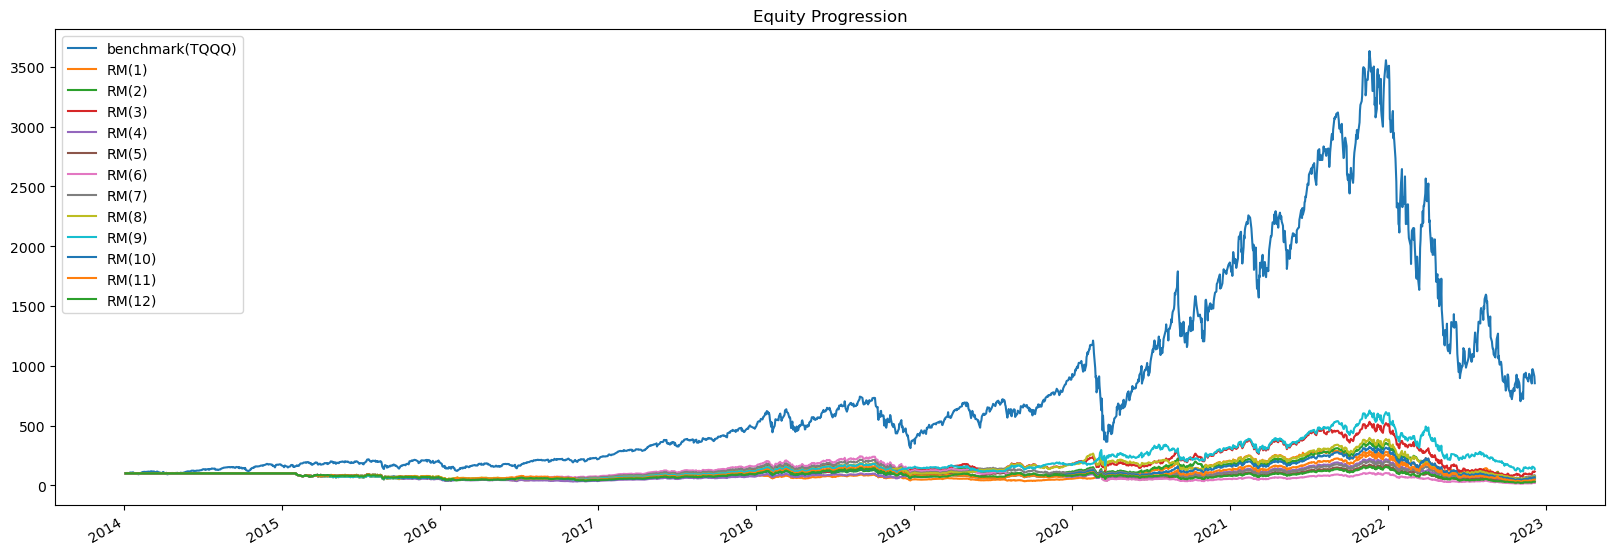

In [10]:
rm_report.plot(figsize=(20,7))

In [11]:
print(rm_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            -26.23%     -45.21%     15.05%      -51.95%     -71.5

In [12]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):   
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, lag, start_day, name='AM({})'.format(str(i+1)))
    
am1_report = bt.run(benchmark, *absolutemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

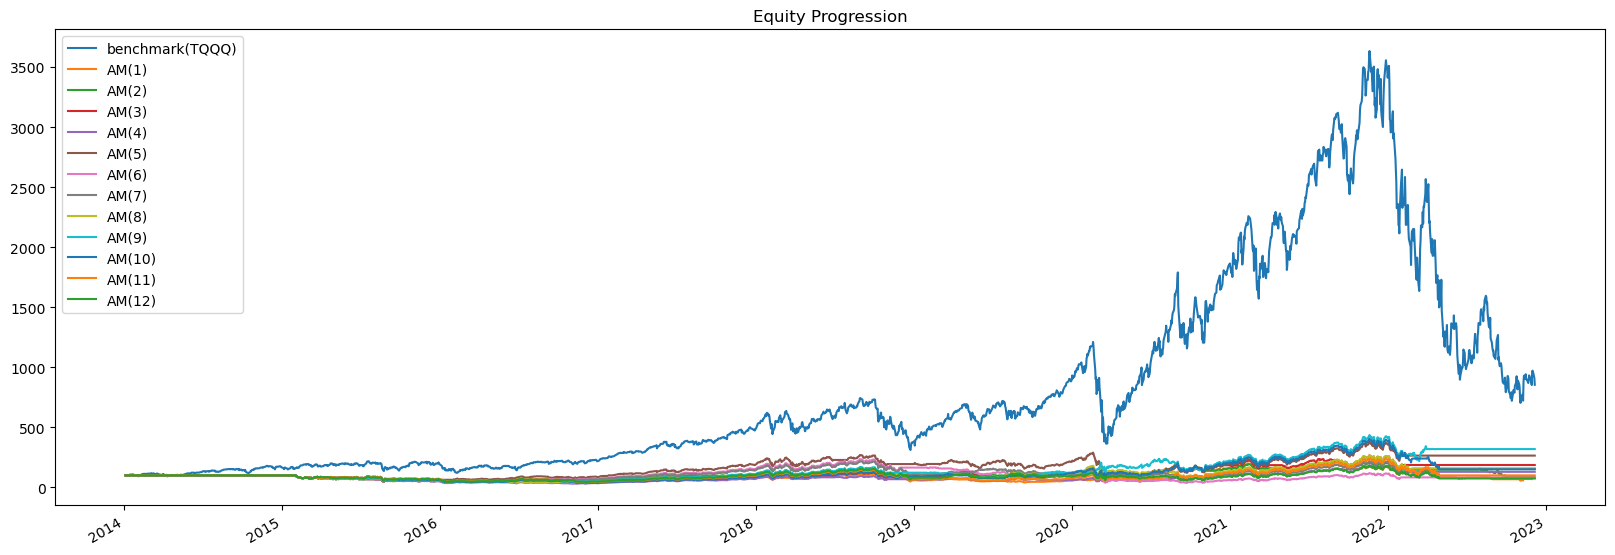

In [13]:
am1_report.plot(figsize=(20,7))

In [14]:
print(am1_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            -13.53%     -22.70%     86.14%      29.34%      164.4

In [21]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, lag, start_day, name='AM({})'.format(str(i+1)))
    
am2_report = bt.run(benchmark, *absolutemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

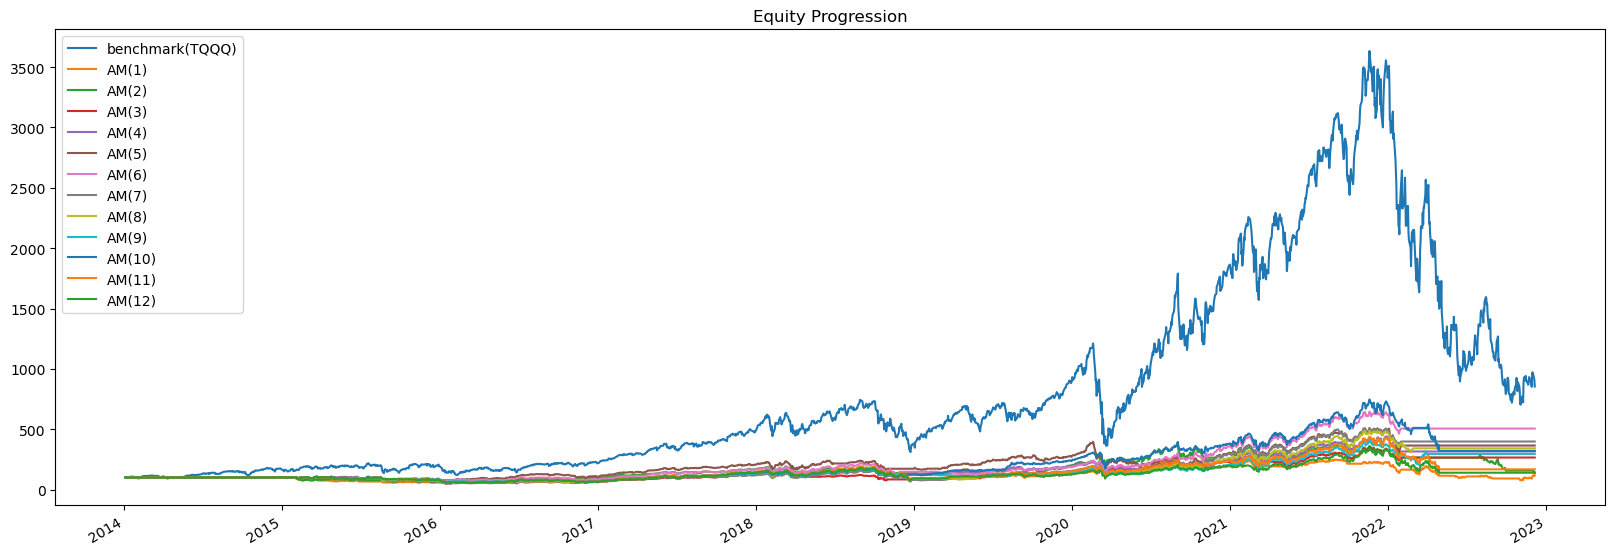

In [22]:
am2_report.plot(figsize=(20,7))

In [23]:
print(am2_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            17.53%      38.76%      165.72%     215.91%     265.0

In [30]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, lag, start_day, name='ODM({})'.format(str(i+1)))

dm1_report = bt.run(benchmark, *dualmomentums.values())

<AxesSubplot:title={'center':'Equity Progression'}>

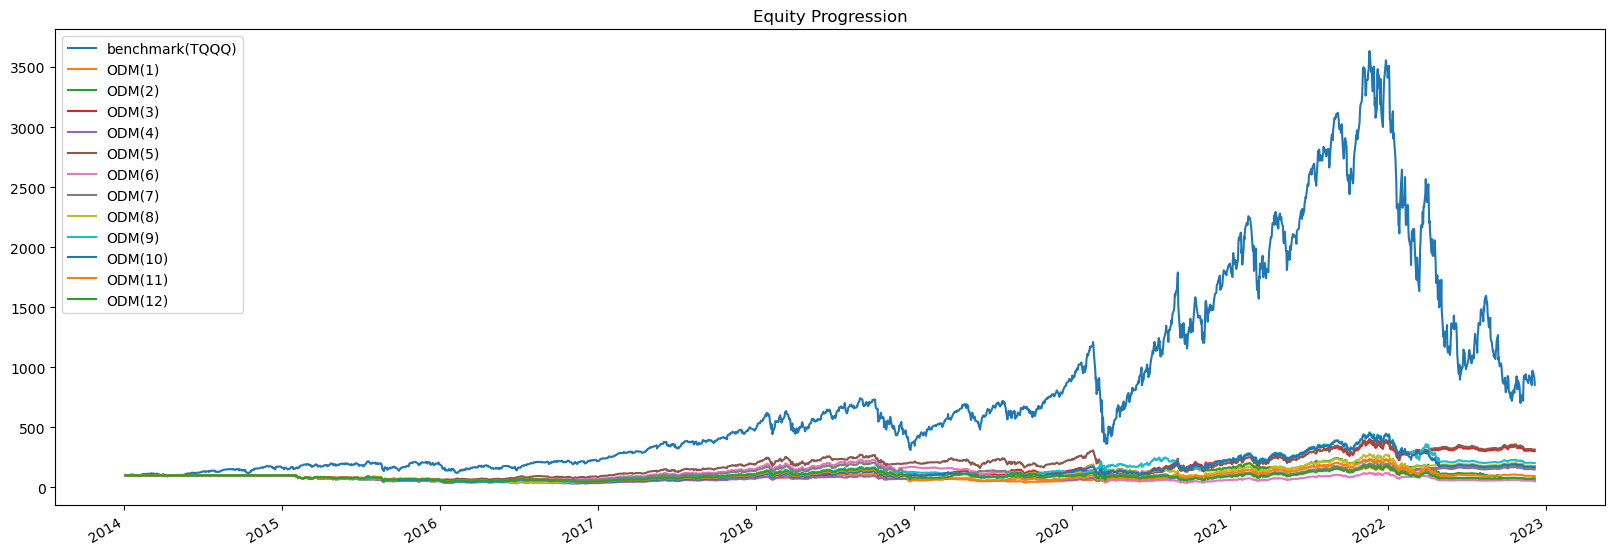

In [31]:
dm1_report.plot(figsize=(20,7))

In [32]:
print(dm1_report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            -12.26%     -47.09%     202.14%     50.24%      215.

In [33]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, lag, start_day, name='ODM({})'.format(str(i+1)))

#dm2_report = bt.run(benchmark, *dualmomentums.values())
dm2_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Equity Progression'}>

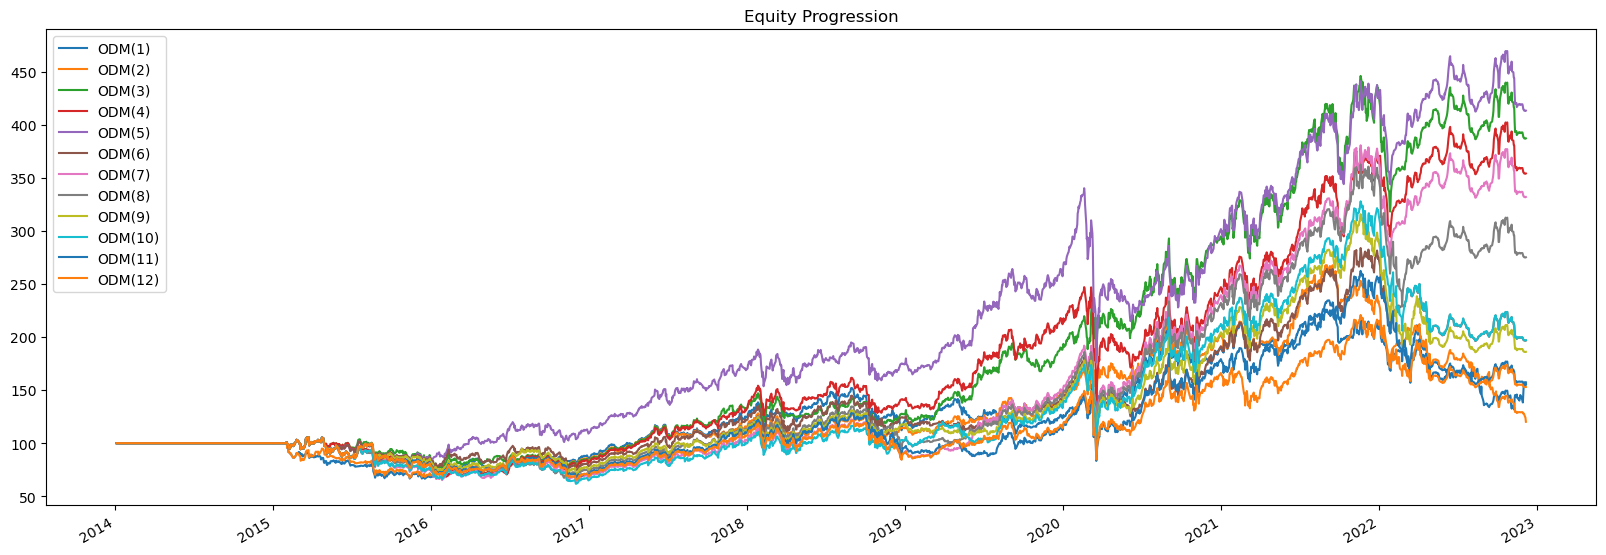

In [34]:
dm2_report.plot(figsize=(20,7))

In [35]:
print(dm2_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         57.27%      20.12%      287.08%     254.03%     313.23%     96.70%      231.90%     175.08%     85.99%      96.90%      55.73%      52.92%
Daily Sharpe         0.35  